# CNN - CIFAR10 - Data Augmentation

In [ ]:
# First, import TF and get its version.
import tensorflow as tf
tf_version = tf.__version__

# Check if version >=2.0.0 is used
if not tf_version.startswith('2.'):
    print('\033[91m' + 'WARNING: TensorFlow >= 2.0.0 will be used in this course.\nYour version is {}'.format(tf_version) + '.\033[0m')
else:
    print('\033[92m' + 'OK: TensorFlow >= 2.0.0' + '.\033[0m')

OK: TensorFlow >= 2.0.0.


In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [ ]:
from IPython.core.debugger import set_trace
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Loading the packages

In [111]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import utils
from sklearn.metrics import confusion_matrix

%matplotlib inline

Define a function to plot some images from CIFAR and load the dataset.

170500096/170498071 [==============================] - 11s 0us/step


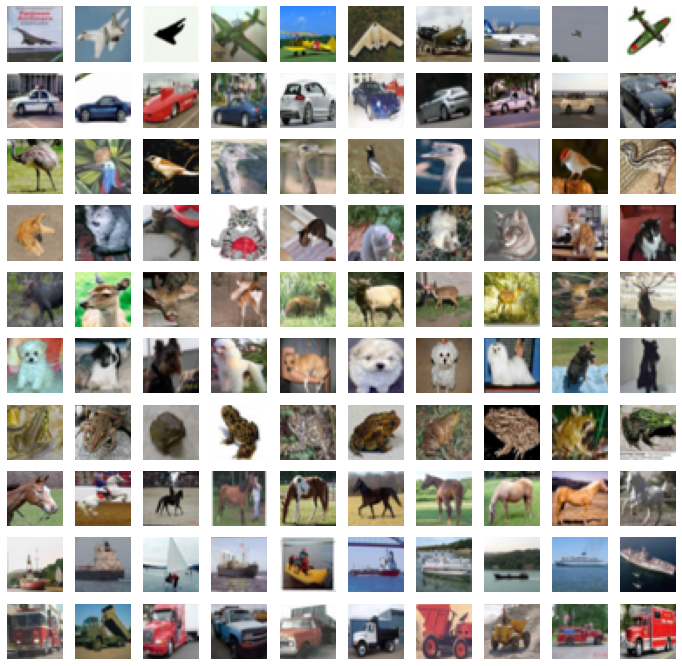

training input shape :  (50000, 32, 32, 3)
training output shape:  (50000, 1)
testing input shape  :  (10000, 32, 32, 3)
testing output shape :  (10000, 1)


In [ ]:
def show_imgs(X,y):
    plt.figure(1, figsize=(12,12))
    k = 0
    for i in range(0,10):
        for j in range(0,10):
            while y[k] != i: k += 1
            plt.subplot2grid((10,10),(i,j))
            plt.imshow(X[k])
            plt.axis('off')
            k += 1
    plt.show()

(X_train, y_train), (X_test, y_test) = cifar10.load_data()
show_imgs(X_test, y_test)
print('training input shape : ', X_train.shape)
print('training output shape: ', y_train.shape)
print('testing input shape  : ', X_test.shape)
print('testing output shape : ', y_test.shape)

### Preprocessing data
After loading and splitting the data, we need to preprocess them by reshaping them into the shape the network expects and scaling them so that all values are in the \[0, 1\] interval.

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.0
X_test /= 255.0
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

50000 train samples
10000 test samples


The target values of the network are supposed to be 1-hot targets. Now the `y_train` is an array with scalar values as in `[5 0 4 1 ...]` and it should be a 1-hot array `Y_train` as in : 

`[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]...]`
 
Note the change of capital letter in the `Y_train` to denote, per convention, an array with multiple dimensions.

In [ ]:
n_classes = 10
Y_train = utils.to_categorical(y_train, n_classes)
Y_test = utils.to_categorical(y_test, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


## Define the network

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the data augmentation pipelines, one for train set, one for test set
# DA v1
if (True):
  datagen = ImageDataGenerator(rotation_range=8,
                               width_shift_range=0.08,
                               height_shift_range=0.08,
                               shear_range=0.3,
                               zoom_range=0.08)

# DA v2
if (False):
  datagen = ImageDataGenerator(featurewise_center=True,
                               featurewise_std_normalization=True,
                               rotation_range=45,
                               width_shift_range=0.33,
                               height_shift_range=0.33,
                               zoom_range=0.5,
                              horizontal_flip=True)

train_datagen = datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE)
test_datagen = datagen.flow(X_test, Y_test, batch_size=BATCH_SIZE)

In [125]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

CLASSES=10
DROPOUT=0.5

def dense_layer(filters, name):
  name = name + "_dense" + str(filters)
  def create(layer):
    layer = Dense(filters, use_bias=False, name=name)(layer)
    layer = BatchNormalization(name=name+"_batchnorm")(layer)
    layer = Activation('relu', name=name+"_activation")(layer)
    layer = Dropout(DROPOUT, name=name+"_dropout")(layer)
    return layer
  return create

def double_dense_layer(filters, name):
  def create(layer):
    layer = dense_layer(filters, name=name+"_1")(layer)
    layer = dense_layer(filters, name=name+"_2")(layer)
    return layer
  return create

def conv_layer(filters, name):
  name = name + "_conv" + str(filters)
  def create(layer):
    layer = Conv2D(filters, kernel_size=(3, 3), kernel_initializer = 'he_normal', padding='same', use_bias=False, name=name)(layer)
    layer = BatchNormalization(name=name+"_batchnorm")(layer)
    layer = Activation('relu', name=name+"_activation")(layer)
    layer = Dropout(DROPOUT, name=name+"_dropout")(layer)
    return layer
  return create

def double_conv_layer(filters, name):
  def create(layer):
    layer = conv_layer(filters, name=name+"_1")(layer)
    layer = conv_layer(filters, name=name+"_2")(layer)
    return layer
  return create

def maxpool_layer(name):
  name = name + "_maxpool"
  def create(layer):
    layer = MaxPooling2D(pool_size=(2, 2), name=name)(layer)
    layer = Dropout(DROPOUT, name=name+"_dropout")(layer)
    return layer
  return create

def upsampling_layer(name):
  name = name + "_upsampling"
  def create(layer):
    layer = UpSampling2D(size=(2,2), name=name)(layer)
    layer = Dropout(DROPOUT, name=name+"_dropout")(layer)
    return layer
  return create

def concat_layer(name):
  name = name + "_concat"
  def create(*layers):
    layer = concatenate(list(layers), axis = 3, name=name)
    layer = Dropout(DROPOUT, name=name+"_dropout")(layer)
    return layer
  return create

def down_block(filters, name):
  name = name + "_down"
  def create(layer):
    layer_high = double_conv_layer(filters, name=name)(layer)
    layer_low = maxpool_layer(name=name)(layer_high)
    return layer_high, layer_low
  return create

def up_block(filters, name):
  name = name + "_up"
  def create(layer_high, layer_low):
    layer = upsampling_layer(name=name)(layer_low)
    layer = concat_layer(name=name)(layer, layer_high)
    layer = double_conv_layer(filters, name=name)(layer)
    return layer
  return create

input = Input((32, 32, 3), name="input")

level1 = input
level1, level2 = down_block(32, "level1")(level1)
level2, level3 = down_block(64, "level2")(level2)
level3, level4 = down_block(128, "level3")(level3)
level4, level5 = down_block(128, "level4")(level4)
level5 = double_conv_layer(256, "level5")(level5)
level4 = up_block(128, "level4")(level4, level5)
level3 = up_block(128, "level3")(level3, level4)
level2 = up_block(64, "level2")(level2, level3)
level1 = up_block(32, "level1")(level1, level2)
output = level1

output = Flatten(name="flatten")(output)
output = double_dense_layer(1024, "output")(output)
output = Dense(CLASSES, activation='softmax', name="output")(output)

model = Model(input, output)

model.summary()

Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
level1_down_1_conv32 (Conv2D)   (None, 32, 32, 32)   864         input[0][0]                      
__________________________________________________________________________________________________
level1_down_1_conv32_batchnorm  (None, 32, 32, 32)   128         level1_down_1_conv32[0][0]       
__________________________________________________________________________________________________
level1_down_1_conv32_activation (None, 32, 32, 32)   0           level1_down_1_conv32_batchnorm[0]
___________________________________________________________________________________________

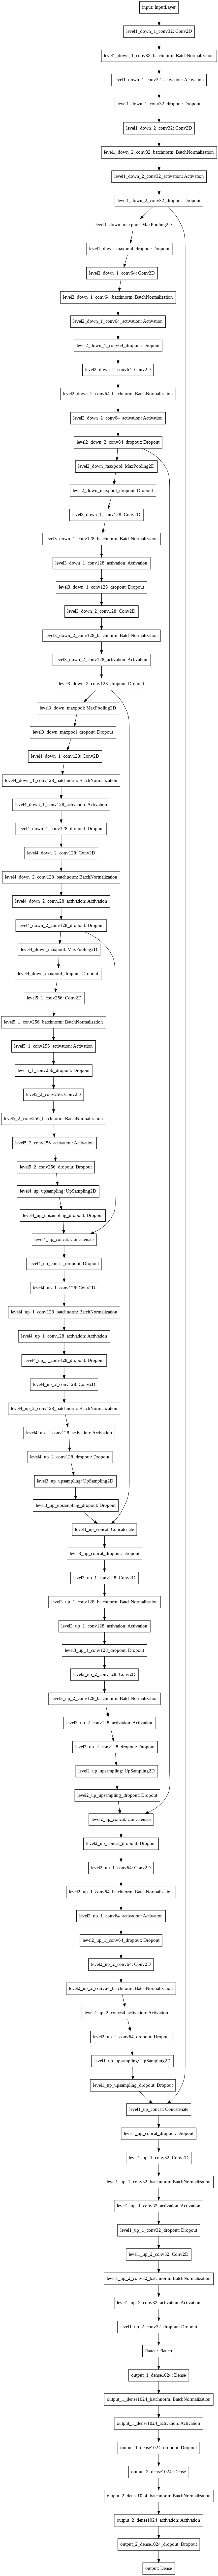

In [126]:
from tensorflow.keras.utils import plot_model
plot_model(model)

## Compile and train the network

In [127]:
EPOCHS = 1000
BATCH_SIZE = 32

model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

log = model.fit(
    X_train, Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(X_test, Y_test),
    callbacks=[early_stopping]
)

Epoch 1/1000
1563/1563 [==============================] - 133s 83ms/step - loss: 2.7710 - accuracy: 0.1267 - val_loss: 3.1462 - val_accuracy: 0.1575
Epoch 2/1000
1563/1563 [==============================] - 128s 82ms/step - loss: 2.0867 - accuracy: 0.2656 - val_loss: 2.6562 - val_accuracy: 0.2109
Epoch 3/1000
1563/1563 [==============================] - 129s 82ms/step - loss: 1.8556 - accuracy: 0.3376 - val_loss: 2.2025 - val_accuracy: 0.2990
Epoch 4/1000
1563/1563 [==============================] - 130s 83ms/step - loss: 1.6836 - accuracy: 0.3961 - val_loss: 1.7926 - val_accuracy: 0.3942
Epoch 5/1000
1563/1563 [==============================] - 130s 83ms/step - loss: 1.5640 - accuracy: 0.4324 - val_loss: 1.5449 - val_accuracy: 0.4608
Epoch 6/1000
1563/1563 [==============================] - 130s 83ms/step - loss: 1.4616 - accuracy: 0.4706 - val_loss: 1.5059 - val_accuracy: 0.4805
Epoch 7/1000
1563/1563 [==============================] - 130s 83ms/step - loss: 1.3869 - accuracy: 0.5013

## Evaluate the network

We can do this at three levels: (1) plot of the loss during the training phase, (2) overall accuracy evaluation on test set and (3) per class evaluation with confusion matrix on test set.

### Loss and accuracy evolution during training
This can be done first looking at the history of the training (output of the `fit()` function).

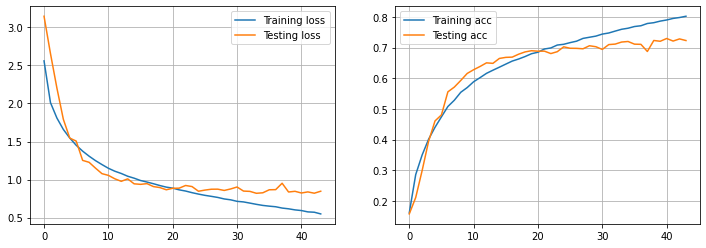

In [128]:
f = plt.figure(figsize=(12,4))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.plot(log.history['loss'], label='Training loss')
ax1.plot(log.history['val_loss'], label='Testing loss')
ax1.legend()
ax1.grid()
ax2.plot(log.history['accuracy'], label='Training acc')
ax2.plot(log.history['val_accuracy'], label='Testing acc')
ax2.legend()
ax2.grid()

### Model evaluation
We can compute the overall performance on test set calling the `evaluate()` function on the model. The function returns the loss and the metrics used to compile the models.

In [129]:
loss_train, metric_train = model.evaluate(X_train, Y_train, verbose=0)
print('Train loss:', loss_train)
print('Train accuracy:', metric_train)

Train loss: 0.35564401745796204
Train accuracy: 0.8823400139808655


In [130]:
loss_test, metric_test = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', loss_test)
print('Test accuracy:', metric_test)

Test loss: 0.8199196457862854
Test accuracy: 0.7182000279426575


### Confusion matrix
We can call the `predict_classes()` function to get the predicted classes. The output of this function is an array with the predicted class labels as in `[5 0 4 1 ...]`. The output array of ground truth `y_test` and the predicted classes can then be fed to the `confusion_matrix()` function of [sklearn metrics package](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix).

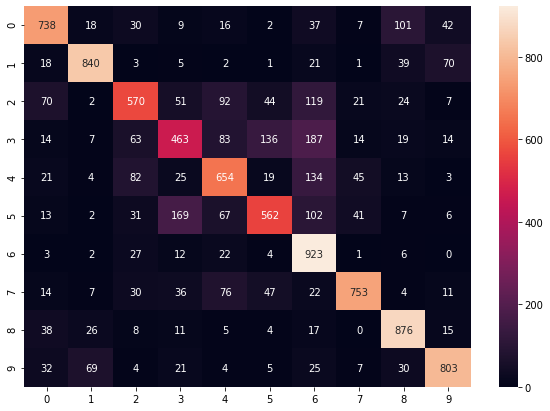

In [131]:
y_pred = model.predict(X_test, verbose=0).argmax(-1)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize = (10,7))
sn.heatmap(conf_matrix, annot=True, fmt='.10g')